In [1]:
import numpy as np
import pandas as pd
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures
import shap

In [7]:
#Create simulation objects

sim_1: SimulationStudy = SimulationStudy(p=10, mean_correlation=0.5, cor_variance=0.1, n=5000)
simulation_1 = sim_1.create_dataset()

sim_2: SimulationStudy = SimulationStudy(p=50,mean_correlation=0.5, cor_variance=0.01, n=5000,  poly_degree=3)
simulation_2 = sim_2.create_dataset()

sim_3: SimulationStudy = SimulationStudy(p=50, mean_correlation=0.8, cor_variance=0.01, n=5000,  poly_degree=3)
simulation_3 = sim_3.create_dataset()


In [ ]:
cov_matrix, mean = SimulationStudy.get_covariance_matrix(sim_1)
cov_matrix = pd.DataFrame(cov_matrix)
cov_matrix

In [8]:
#Split into train and test set
def get_split(simulation: pd.DataFrame) -> np.ndarray:
    
    train_df, test_df = train_test_split(simulation, test_size=0.5, random_state=42)

    # Extract features and target variables for training
    X_train = train_df[[col for col in simulation.columns if col.startswith('X')]].values
    T_train = train_df[['T']].values
    Y_train = train_df['y'].values

    # Extract features and true CATE for testing
    X_test = test_df[[col for col in simulation.columns if col.startswith('X')]].values
    T_test = test_df[['T']].values
    y_test = test_df['y'].values

    true_cate_test = test_df['CATE']

    return train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test

In [9]:
train_df_1, test_df_1, X_train_1, Y_train_1, T_train_1, X_test_1, T_test_1, y_test_1, true_cate_test_1 = get_split(simulation_1)
train_df_2, test_df_2, X_train_2, Y_train_2, T_train_2, X_test_2, T_test_2, y_test_2, true_cate_test_2 = get_split(simulation_2)
train_df_3, test_df_3, X_train_3, Y_train_3, T_train_3, X_test_3, T_test_3, y_test_3, true_cate_test_3 = get_split(simulation_3)

OLS Model

In [10]:
#Create OLS model
ols = LinearRegression()

In [11]:
#Estimate a fully feature-treatment interacted model
interaction_term = X_train_1 * T_train_1
X_train_ols = np.hstack([X_train_1, T_train_1, interaction_term])

ols.fit(X_train_ols, Y_train_1)


LinearRegression()

In [12]:
#Cannot currently estimate CATE functions from OLS to compare with true CATEs
#Treatment and control groups have different sizes

interaction_term_test = X_test_1 * T_test_1
X_test_ols = np.hstack([X_test_1, T_test_1, interaction_term_test])

treatment_col_index = sim_1.p

# Generate treatment and control groups
treatment_group = X_test_ols[X_test_ols[:, treatment_col_index] == 1]
control_group = X_test_ols[X_test_ols[:, treatment_col_index] == 0]

# Predict outcomes
pred_treatment = ols.predict(treatment_group)
pred_control = ols.predict(control_group)

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(estimated_cate_ols, true_cate_test_1, alpha=0.5, label='OLS')
plt.plot([min(true_cate_test_1), max(true_cate_test_1)], [min(true_cate_test_1), max(true_cate_test_1)], '--', color='red')
plt.xlabel('Estimated CATE')
plt.ylabel('True CATE')
plt.title('Estimated vs. True CATE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
estimated_cate_ols=estimated_cate_ols.reshape(-1, 1)
true_cate_test=true_cate_test_1.reshape(-1,1)
reg = LinearRegression().fit(estimated_cate_ols, true_cate_test)
reg.score(estimated_cate_ols, true_cate_test)

Causal Forest DML

In [13]:
#define model_t to reflect known treatment probabilities
model_t = DummyClassifier()

#Estimate the causal forest model
est = CausalForestDML(model_y='auto',
                      model_t=model_t,
                      discrete_treatment=True,
                      cv=5,
                      n_estimators=1000,
                      #featurizer=PolynomialFeatures(degree=3, include_bias=False),
                      random_state=42,
                      criterion='mse',
                      honest=True)

est.fit(Y=Y_train_1, T=T_train_1, X=X_train_1, W=None, cache_values=True)


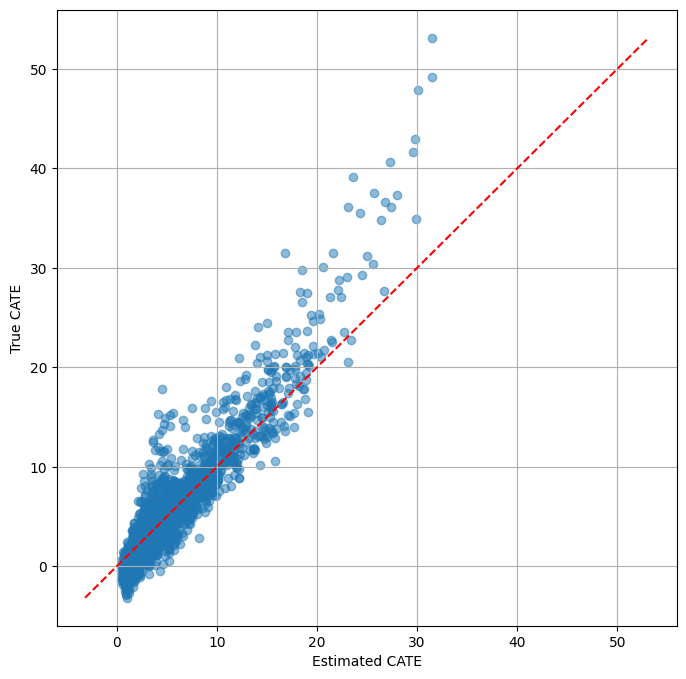

In [14]:
#Plot true CATE and estimate DML CATE
estimated_cate = est.effect(X_test_1)

plt.figure(figsize=(8, 8))
plt.scatter(estimated_cate, true_cate_test_1, alpha=0.5)
plt.plot([min(true_cate_test_1), max(true_cate_test_1)], [min(true_cate_test_1), max(true_cate_test_1)], '--', color='red')
#plt.plot()
plt.xlabel('Estimated CATE')
plt.ylabel('True CATE')
plt.grid(True)
plt.show()

In [15]:
estimated_cate=estimated_cate.reshape(-1, 1)
reg = LinearRegression().fit(estimated_cate, true_cate_test_1)
reg.score(estimated_cate, true_cate_test_1)

0.8821195897962013